In [ ]:
# !pip install arviz==0.6.1 -q
# !pip install pymc3==3.8 -q
# !pip install Theano==1.0.4 -q

     |████████████████████████████████| 1.4MB 5.3MB/s 
     |████████████████████████████████| 4.7MB 19.7MB/s 
     |████████████████████████████████| 317kB 46.8MB/s 
     |████████████████████████████████| 911kB 4.5MB/s 
     |████████████████████████████████| 2.8MB 4.3MB/s 


In [151]:
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import IPython
import seaborn as sns
import arviz as az
import csv
import json
# from google.colab import files

print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.8
Running on ArviZ v0.9.0


In [86]:
#@ def, Plot heatmaps subplots 
def plotHeatmaps(data,
                 rowTitles,
                 colTitles,
                 xLabel,
                 yLabel,
                 nRows,
                 nCols,
                 vmins,
                 vmaxs,
                 iRow):
    
    fig = plt.figure(figsize=[7,13])
    
    # im identifier:
    im = [None]*nCols
    x1, x2 = data[0] # Free parameters of the data.
    f = data[1] # Data that is the function of the free parameters.
    
    # Return the last row that is 'True' in 'plotWhat'. It sets in what row 
    # to show 'xlabel':
    max_plotWhat = np.max(np.where(plotWhat))
    
    # plot the nRows x nCols subplots with labels, titles at  
    # sceciefic locations. iCol is Column index, iRow is Row index:
    for iCol in range(nCols):
        fig.add_subplot(nRows, nCols, iRow*nCols + iCol+1)
        im[iCol] = plt.pcolor(x1 ,x2, f[iCol],
                              vmin=vmins[iCol], vmax=vmaxs[iCol],
                              shading='auto')
        fig.colorbar(im[iCol])
        
        if iRow == 0:
            plt.title(colTitles[iCol] + rowTitles[iRow])
        
        else:
            plt.title(rowTitles[iRow])
        
        if iRow == max_plotWhat:
            plt.xlabel(xLabel)
            
        if iCol == 0:
            plt.ylabel(yLabel)
    
    fig.tight_layout()
    

In [142]:
DataToPlot = 4*[None]
plotWhat = [True,False,False,False]

def plotData(DataToPlot,plotWhat):
    # titles and labels:
    xLabel = "$log_{10}(Poff_{LCK*}^{LA}$)"
    yLabel = "$log_{10}(D_{LCK*}^{LA}) (\mu m^2/sec)$"

    lambdaALck_Title = "$\lambda_{Lck*}^{LckA}(nm^{-1})$\n"
    decayLengthALck_Title = "$Decaylength_{Lck*}^{LckA}(nm)$\n" # Decaylength
    colTitles = [lambdaALck_Title,decayLengthALck_Title]
    
    
    rowTitles = ["Training data","Fit data","Trained parameters","Surrogate"]

    # min and max values for the different heatmaps:
    vmins = [0,0]
    vmaxs = [0.1,4.0]

    nRows = 4
    nCols = 2
    
    # Plot a row of subplot if the data is not empty and if value is 'True':
    for iRow in range(nRows):
        if DataToPlot[iRow] != None and plotWhat[iRow]:
            plotHeatmaps(data = DataToPlot[iRow],
                         nRows = nRows,
                         nCols = nCols,
                         rowTitles = rowTitles,
                         colTitles = colTitles,
                         xLabel = xLabel,
                         yLabel = yLabel,
                         vmins = vmins,
                         vmaxs = vmaxs,
                         iRow = iRow)


In [132]:
#@title Training data for model2 { vertical-output: true, display-mode: "form" }
# lambdaALCK_array0: x-axis is Poff (probability of spontaneous decay); 
# y-axis is Diff (diffusion coefficient in micron^2/sec); 
# z-axis is exponontial factor 'lambda': 'y = exp(-lambda*x)' in 1/nm.
lambdaALCK_array0 = -1*np.array([[-0.014657,-0.014447,-0.014664,-0.015526,-0.01714,-0.022992,-0.034524,-0.070557,-0.11387,-0.20832,-0.01],
[-0.012456,-0.012384,-0.013487,-0.013015,-0.01379,-0.018903,-0.03389,-0.052318,-0.093198,-0.15276,-0.01],
[-0.0098342,-0.0096907,-0.0098001,-0.010041,-0.011918,-0.017406,-0.026369,-0.039222,-0.057673,-0.11743,-0.01],
[-0.0080017,-0.0077559,-0.0076087,-0.0082535,-0.0099144,-0.012286,-0.01889,-0.03604,-0.054248,-0.095491,-0.01],
[-0.0058524,-0.0056572,-0.0072154,-0.0066482,-0.0078467,-0.010037,-0.014898,-0.028174,-0.04584,-0.071974,-0.01],
[-0.0046865,-0.0047947,-0.0044626,-0.0045893,-0.0049986,-0.0081368,-0.014763,-0.019339,-0.035599,-0.060622,-0.01],
[-0.0036558,-0.0031606,-0.0036487,-0.0046674,-0.0031157,-0.0048789,-0.011206,-0.019952,-0.028773,-0.07807,-0.01],
[-0.0024369,-0.0024442,-0.0025014,-0.0024395,-0.0035739,-0.0049891,-0.0062023,-0.010665,-0.018304,-0.029732,-0.01],
[-0.0016189,-0.0017432,-0.0013415,-0.0026006,-0.0021152,-0.0028547,-0.0089079,-0.0074472,-0.017615,-0.024174,-0.01],
[-0.0013258,-0.00074239,-0.00067486,-0.0013035,-0.0019591,-0.0021911,-0.0065414,-0.0074576,-0.016519,-0.65039,-0.01],
[-0.00060974,-0.00027457,-0.00018559,-0.00016811,-0.00085357,-0.0020511,-0.0026312,-0.0053513,-0.038536,-0.014071,-0.01],
[-0.00052181,-0.00050238,-0.00016453,-0.00011248,-0.00068145,-0.00015995,-0.0014959,-0.0041252,-0.0048673,-0.0055963,-0.01],
[-7.0125e-05,-0.00049168,-0.00062104,-0.00094581,-6.2083e-05,-0.0002202,-0.00032468,-0.0053617,-0.01093,-0.01741,-0.01]])

# cropping the last column:
lambdaALCK_array = lambdaALCK_array0[:,:-1]
decayLengthALCK_array = 1./lambdaALCK_array

logDiff = np.arange(-3, 0.25, 0.25); print(['logDiff.shape =',logDiff.shape])
logPoff = np.arange(-5, 0.0, 0.5); print(['logPoff.shape =',logPoff.shape])

logPoff_array, logDiff_array  = np.meshgrid(logPoff, logDiff)

if True:
    np.save("lambdaALCK_array.npy", lambdaALCK_array)
    np.save("decayLengthALCK_array.csv", decayLengthALCK_array)
    
if False:
    files.download("lambdaALCK_array.npy") # Download locally from colab
    files.download("decayLengthALCK_array.npy") # Download locally from colab

['logDiff.shape =', (13,)]
['logPoff.shape =', (10,)]


In [133]:
#@title Convert trainingData to dataFrames
df_trainingData_model2 = pd.DataFrame(np.array([logPoff_array.flatten(), 
                   logDiff_array.flatten(),  
                   lambdaALCK_array.flatten(), #
                   decayLengthALCK_array.flatten()]).T, # 
                   columns=['logPoff','logDiff', 'lambdaALCK','decayLengthALCK'])

df_trainingData_model2.to_csv('trainingData_model2.csv')

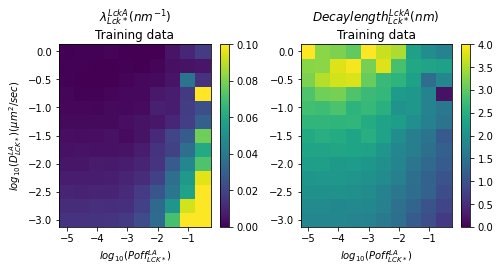

In [143]:

df_lambdaALCK = df_trainingData_model2.pivot('logDiff', 'logPoff', 'lambdaALCK')
df_decayLengthALCK = df_trainingData_model2.pivot('logDiff', 'logPoff', 'decayLengthALCK')

df_logPoff = df_decayLengthALCK.columns
df_logDiff = df_decayLengthALCK.index

lambdaALCK = df_lambdaALCK.values
decayLengthALCK = np.log10(df_decayLengthALCK.values)

DataToPlot[0] = [[df_logPoff,df_logDiff],[lambdaALCK,decayLengthALCK]]
plotWhat=[True,False,False,False]

plotData(DataToPlot, plotWhat)


In [154]:
#@title 2.2.1 Defined fit fnctions
# fl is for 'flatten'

def linear_z(xy, b, ax, ay):
    x,y = xy
    f = b + ax*x + ay*y
    strf = "b + ax*x + ay*y"
    return f

def sig(x, min, max, center, devisor):

    f = min + (max - min)/(1 + np.exp(-(x - center)/devisor))
    return f

In [155]:
#@title Read training data from csv file
# Reading data from csv file:
df_trainingData_model2 = pd.read_csv('trainingData_model2.csv')

# Reading data from DataFrame:
# 'f' is for 'flatten'  
flogPoff = df_trainingData_model2['logPoff']
flogDiff = df_trainingData_model2['logDiff']
flambdaALCK = df_trainingData_model2['lambdaALCK']
fdecayLengthALCK = df_trainingData_model2['decayLengthALCK']


In [156]:
#@title 2.2.2. Get fit parameters
def get_fit_parameters(X,fitFunc,fXdata,parametersNames,p0):
    """
    Returns fit parameters and aranges them in DataFrames where the index (rows)
    are the fit parameters' names and the columns are 'mu' and 'sd'.
    """
    popt, pcov = curve_fit(fitFunc, X, fXdata, p0)
    mu = popt
    sd = np.sqrt(np.diag(pcov))

    data = {'mu':mu,'sd':sd}
    index = parametersNames
    
    df = pd.DataFrame(data,index=index)

    return df

In [158]:
#@title Fit parameters for lambdaALCK
"""TODO: maybe define p0_wTCR in another place"""
p0_lambdaALCK = 0., 0., 0.
parametersNames_lambdaALCK = ['intercept', 'PoffSlope', 'DiffSlope']

df_fitParameters_lambdaALCK = get_fit_parameters(X=(flogPoff,flogDiff),
                              fitFunc=linear_z,
                              fXdata=np.log10(flambdaALCK),
                              parametersNames=parametersNames_lambdaALCK,
                              p0=p0_lambdaALCK)

df_fitParameters_lambdaALCK = df_fitParameters_lambdaALCK.round(3)
display(df_fitParameters_lambdaALCK)

,mu,sd
intercept,-2.168,0.078
PoffSlope,0.308,0.020
DiffSlope,-0.547,0.031


In [159]:
#@title Fit parameters for lambdaALCK
"""TODO: maybe define p0_wTCR in another place"""
p0_decayLengthALCK = 0., 0., 0.
parametersNames_decayLengthALCK = ['intercept', 'PoffSlope', 'DiffSlope']

df_fitParameters_decayLengthALCK = get_fit_parameters(X=(flogPoff,flogDiff),
                              fitFunc=linear_z,
                              fXdata=np.log10(fdecayLengthALCK),
                              parametersNames=parametersNames_decayLengthALCK,
                              p0=p0_decayLengthALCK)

df_fitParameters_decayLengthALCK = df_fitParameters_decayLengthALCK.round(3)
display(df_fitParameters_decayLengthALCK)

,mu,sd
intercept,2.168,0.078
PoffSlope,-0.308,0.020
DiffSlope,0.547,0.031


In [160]:
#@title 2.2.3. Plotting training data vs. data fit
# lambdaALCK:, 
lambdaALCK_fit = df_fitParameters_lambdaALCK.loc['intercept','mu'] + \
           df_fitParameters_lambdaALCK.loc['PoffSlope','mu']*logPoff_array + \
           df_fitParameters_lambdaALCK.loc['DiffSlope','mu']*logDiff_array

# decayLengthALCK:
decayLengthALCK_fit = df_fitParameters_decayLengthALCK.loc['intercept','mu'] + \
            df_fitParameters_decayLengthALCK.loc['PoffSlope','mu']*logPoff_array + \
            df_fitParameters_decayLengthALCK.loc['DiffSlope','mu']*logDiff_array

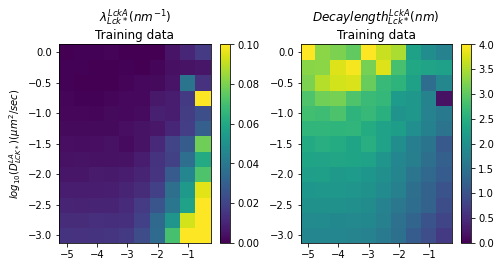

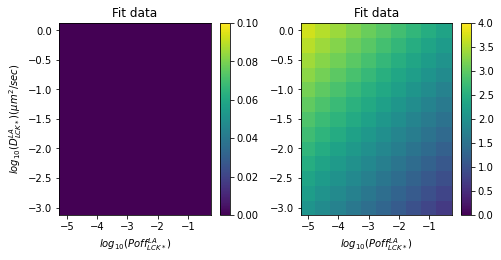

In [161]:
DataToPlot[1] = [[logPoff,logDiff],[lambdaALCK_fit,decayLengthALCK_fit]]
plotWhat=[True,True,False,False]

plotData(DataToPlot, plotWhat)

# 2.3. Data structure

In [162]:
#@title Class RV new
class RV: # TODO for Barak - make CSV field names correspond to dictionary names or have a meta-dict for it
    def __init__(self,
                 id : str,
                 type2 : str,
                 shortName : str,
                 texName : str,
                 description : str,
                 distribution : str,
                 distributionParameters : dict,
                 units : str):
        
        self.id = id # str
        self.type2 = type2 # str
        self.shortName = shortName # str
        self.texName = texName # str
        self.description = description # str
        self.distribution = distribution # str
        self.distributionParameters = distributionParameters # array
        self.units = units # str


    def get_as_dictionary(self):  
        return {'ID': self.id, # Unique variable name that is used by pymc3, e.g. rv_tSlope_wTCR_KSEG1.
                'Type': self.type2, # Type of variable, e.g. 'Free parameter', 'Random variable'
                'Short Name': self.shortName, # Short name, e.g. 't'.
                'Latex Name': self.texName, # LaTex name for display.
                'Description': self.description, # 
                'Distribution': self.distribution,
                'Distribution parameters': self.distributionParameters,
                'Units': self.units}   

    def get_pymc3_statement():
        '''
        TASK 1
        TODO make this return a 2-tuple from a variable name 
        to a pymc3 statment for creating this random variable
        (to be used as input for eval)
        '''
#         if RV.distribution == "Normal":
#             mu = RV.distributionParameters["mu"]
#             sd = RV.distributionParameters["sd"]
#             s0 = RV.id
#             if RV.shortName == "output":
#                 print(RV.shortName)
#             s1 = ("pm." + RV.distribution + "('" + RV.id  + "'" + \
#                                       ", mu=" + str(mu) + \
#                                       ", sd=" + str(sd) + ")")
#             s = (s0,s1)
#             print(eval("s[0]"),"=",eval("s[1]"))
        '''
        Example: return tuple :
        s = ('rv_alpha', 'pm.Normal("rv_alpha", mu=354, sigma=a*10+b*20)')
        so we can do eval(s[0]) = eval(s[1])
        '''
      # TODO: WRITE-ME
#       return

    @staticmethod
    def RV_from_dictionary(d : dict):
          ''' generates an RV object from a dictionary produced by get_as_dictionary() '''  
          return RV(id=d['ID'],
                    type2=d['Type'],
                    shortName=d['Short Name'],
                    texName=d['Latex Name'],
                    description=d['Description'],
                    distribution=d['Distribution'],
                    distributionParameters=d['Distribution parameters'],
                    units=d['Units'])


In [163]:
#@title Class model

class Model:
    # Constructor
    def __init__(self, 
                 shortName : str, 
                 longName : str, 
                 description : str, 
                 model_id  : str,
                 RV_csv_file = None, # Topology of Bayes net
                 data_csv_file = None): # Training data
        '''
        '''
        self.shortName = shortName # str
        self.longName = longName # str
        self.description = description # str
        self.model_id = model_id # str
        self.set_RVs_from_csv(RV_csv_file) # fill in random variables from CSV file
        self.set_data_from_csv(data_csv_file) # fill in training data from CSV file

    # add a random variable to the model
    def add_rv(self, rv): # BARAK
        self.RVs.append(rv)

    def get_dataframe(self): # TODO: think about the name
        info = [ rv.get_as_dictionary() for rv in self.RVs ]
        df = pd.DataFrame(info)
        df.set_index('ID', drop=False)  
        return df

    def to_csv(self, csv_file): # TODO: think about the name
        df = self.get_dataframe()
        df.to_csv(csv_file)

    def set_RVs_from_csv(self, csv_file):
        ''' 
        read csv file (similar to Table S1 in metamodeling paper) with random variables
        and set this model's random variables and the statistical relations among them
        accordingly

        If csv_file is None, set an empty list of RVs
        '''
        self.RVs = []
        if csv_file == None:
            return
        df = pd.read_csv(csv_file)
        # TODO: assert that it has all the right fields
        rv_dicts = df.to_dict('records') # TODO: check if this is still appropraite
        print("RV dicts from csv:")
        print(rv_dicts)
        for rv_dict in rv_dicts:
            rv= RV.from_dictionary(rv_dict)
            self.add_rv(rv)

    def set_data_from_csv(self, data_csv_file):
    # TASK 2
        # df = pd.read_csv(data_csv_file)
        # display(df) # Yair
        # TODO: code for filling in table of data
        # self.data = ... # WRITE-ME
        self.trainingData = pd.read_csv(data_csv_file)

    # generate a pymc3 model from this model
    def get_as_pymc3(self): # BARAK
    # TASK 3 - make sure this works
        '''
        Go over all random variables in this model, 
        and generate a PyMC3 object with cooresponding
        variable names and statistical relations among them
        '''
        # TODO (use "eval" command)
        pm_model = pm.Model()
        with pm_model as pm:
             for rv in self.RVs:
                 pass
            #    s = rv.get_pymc3_statement()
            #    eval(s[0]) = eval(s[1])
        return pm_model

    def update_rvs_from_pymc3(self, pymc3): # BARAK
    # TASK 4 
        # TODO: use trace from trained PyMC3 model to update statements for all RVs
        return

    
     

In [179]:
#@title Start model2_lambdaALCK
model2_description = """Steady state of the spatial distribution of active Lck,
(Lck*), molecules relative to a fixed CD45 location. The distribution of the Lck*
molecules is determined by their diffusion coefficient and their spontanous decay
probability."""

model2_lambdaALCK = Model(shortName = 'LckA',  # str
               longName = 'Lck activation', # str
               description = 'Model2 description', # str
               model_id = '2', # str
               RV_csv_file = None,
               data_csv_file = 'trainingData_model2.csv') 

# models.RV_csv_file
# models.set_data_from_csv('trainingData_models.csv')
# display(models_wTCR.trainingData)

In [180]:
#@title Start model2_decayLengthALCK
model2_decayLengthALCK = Model(shortName = 'LckA',  # str
               longName = 'Lck activation', # str
               description = 'Model2 description', # str
               model_id = '2', #, # str
               RV_csv_file = None,
               data_csv_file = 'trainingData_model2.csv') 


In [181]:
#@title 2.4. Setting random variables


In [182]:
#@title 2.4.1. Untrained random variables parameters


In [199]:
#@title Define lambdaALCK untrained table

model2_lambdaALCK.add_rv(
    RV(id = 'fp_logPoff_lambdaALck_ALCK2',
       type2 = 'Free parameter',
       shortName = 'logPoff',
       texName = "$$logPoff^{ALCK}$$",
       description = 'Log10 of deactivation probability',
       distribution = 'Normal',
       distributionParameters = {'mu' :-4., 'sd' : 1.},
       units = '$$-$$'))

model2_lambdaALCK.add_rv(
    RV(id = 'fp_logDiff_lambdaALck_ALCK2',
        type2 = 'Free parameter',
        shortName = 'logDiff',
        texName = '$$logDiff^{ALCK}$$',
        description = 'Log10 of diffuion coefficient',
        distribution = 'Normal',
        distributionParameters = {'mu' : -2., 'sd' : 1.},
        units = '$$\mum^2/sec$$'))

model2_lambdaALCK.add_rv(
    RV(id = 'rv_intercept_lambdaALck_ALCK2',
        type2 = 'Random variable',
        shortName = 'intercept',
        texName = '$$\lambda^{ALCK}_{intercepct}$$',
        description = 'Intercept of plain with origin',
        distribution = 'Normal',
        distributionParameters = {'mu' : df_fitParameters_lambdaALCK.loc['intercept','mu'], # TODO: get from table 
                                  'sd' : df_fitParameters_lambdaALCK.loc['intercept','sd']},
        units = '$$nm^{-1}$$')) 

model2_lambdaALCK.add_rv(
    RV(id = 'rv_PoffSlope_lambdaALck_ALCK2',
        type2 = 'Random variable',
        shortName = 'PoffSlope',
        texName = '$$\lambda^{ALCK}_{PoffSlope}$$',
        description = 'Plain slope for logPoff',
        distribution = 'Normal',
        distributionParameters = {'mu' : df_fitParameters_lambdaALCK.loc['PoffSlope','mu'], # TODO: get from table 
                                  'sd' : df_fitParameters_lambdaALCK.loc['PoffSlope','sd']},
        units = '$$-$$')) 

model2_lambdaALCK.add_rv(
    RV(id = 'rv_DiffSlope_lambdaALck_ALCK2',
        type2 = 'Random variable',
        shortName = 'DiffSlope',
        texName = '$$\lambda^{ALCK}_{DiffSlope}$$',
        description = 'Plain slope for logDiff',
        distribution = 'Normal',
        distributionParameters = {'mu' : df_fitParameters_lambdaALCK.loc['PoffSlope','mu'], # TODO: get from table 
                                  'sd' : df_fitParameters_lambdaALCK.loc['PoffSlope','sd']},
        units = '$$-$$')) 

model2_lambdaALCK.add_rv(
    RV(id = 'rv_output_lambdaALck_ALCK2',
       type2 = 'Random variable',
       shortName = 'output',
       texName = '$$\lambda^{ALCK}_{output}$$',
       description = 'lambdaALck output',
       distribution = 'Normal',
       distributionParameters = {'mu' : 0.1, 'sd' : 0.1},
       units = "$$nm^{-1}$$")) 

model2_lambdaALCK.to_csv("model2_lambdaALCK.csv")

In [184]:
#@title Define lambdaALCK untrained table

# decayLengthALCK
model2_decayLengthALCK.add_rv(
    RV(id = 'fp_logPoff_decayLengthALCK_ALCK2',
       type2 = 'Free parameter',
       shortName = 'logPoff',
       texName = "$$logPoff^{ALCK}$$",
       description = 'Log10 of deactivation probability',
       distribution = 'Normal',
       distributionParameters = {'mu' :-4., 'sd' : 1.},
       units = '$$-$$'))

model2_decayLengthALCK.add_rv(
    RV(id = 'fp_logDiff_decayLengthALCK_ALCK2',
        type2 = 'Free parameter',
        shortName = 'logDiff',
        texName = '$$logDiff^{ALCK}$$',
        description = 'Log10 of diffuion coefficient',
        distribution = 'Normal',
        distributionParameters = {'mu' : -2., 'sd' : 1.},
        units = '$$\mum^2/sec$$'))

model2_decayLengthALCK.add_rv(
    RV(id = 'rv_intercept_decayLengthALCK_ALCK2',
        type2 = 'Random variable',
        shortName = 'intercept',
        texName = '$$\lambda^{ALCK}_{intercepct}$$',
        description = 'Intercept of plain with origin',
        distribution = 'Normal',
        distributionParameters = {'mu' : df_fitParameters_decayLengthALCK.loc['intercept','mu'], # TODO: get from table 
                                  'sd' : df_fitParameters_decayLengthALCK.loc['intercept','sd']},
        units = '$$nm^{-1}$$')) 

model2_decayLengthALCK.add_rv(
    RV(id = 'rv_PoffSlope_decayLengthALCK_ALCK2',
        type2 = 'Random variable',
        shortName = 'PoffSlope',
        texName = '$$\lambda^{ALCK}_{PoffSlope}$$',
        description = 'Plain slope for logPoff',
        distribution = 'Normal',
        distributionParameters = {'mu' : df_fitParameters_decayLengthALCK.loc['PoffSlope','mu'], # TODO: get from table 
                                  'sd' : df_fitParameters_decayLengthALCK.loc['PoffSlope','sd']},
        units = '$$-$$')) 

model2_decayLengthALCK.add_rv(
    RV(id = 'rv_DiffSlope_decayLengthALCK_ALCK2',
        type2 = 'Random variable',
        shortName = 'DiffSlope',
        texName = '$$decayLength^{ALCK}_{DiffSlope}$$',
        description = 'Plain slope for logDiff',
        distribution = 'Normal',
        distributionParameters = {'mu' : df_fitParameters_decayLengthALCK.loc['PoffSlope','mu'], # TODO: get from table 
                                  'sd' : df_fitParameters_decayLengthALCK.loc['PoffSlope','sd']},
        units = '$$-$$')) 

model2_decayLengthALCK.add_rv(
    RV(id = 'rv_output_decayLengthALCK_ALCK2',
       type2 = 'Random variable',
       shortName = 'output',
       texName = '$$decayLength^{ALCK}_{output}$$',
       description = 'Decay length output',
       distribution = 'Normal',
       distributionParameters = {'mu' : 3000., 'sd' : 500.},
       units = "$$nm$$")) 

model2_decayLengthALCK.to_csv("model2_decayLengthALCK.csv")

In [186]:
#@title 2.4.2. Untrained random variables tables


In [187]:
#@title Display RVs tables as DataFrames

# Display decayLengthALCK untrained table:
df_model2_lambdaALCK_untrainedTable = model2_lambdaALCK.get_dataframe()
df_model2_lambdaALCK_untrainedTable = df_model2_lambdaALCK_untrainedTable.set_index('ID')

display(df_model2_lambdaALCK_untrainedTable.style.set_properties(**{'text-align': 'left',
                                               'background-color': 'rgba(0, 150, 255, 0.15)',
                                               'border' : '1px black solid',
                                               'width': '50px'}))

# (df.style
#   .background_gradient(cmap=cm, subset=['total_amt_usd_diff','total_amt_usd_pct_diff'])
#   .highlight_max(subset=['total_amt_usd_diff','total_amt_usd_pct_diff'])
#   .set_caption('This is a custom caption.')
#   .format({'total_amt_usd_pct_diff': "{:.2%}"})
#   .set_table_styles(styles))

# Display model2_decayLengthALCK untrained table:
df_model2_decayLengthALCK_untrainedTable = model2_decayLengthALCK.get_dataframe()
df_model2_decayLengthALCK_untrainedTable = df_model2_decayLengthALCK_untrainedTable.set_index('ID')

display(df_model2_decayLengthALCK_untrainedTable.style.set_properties(**{'text-align': 'left',
                                                'background-color': 'rgba(0, 150, 255, 0.40)',
                                                'border' : '1px black solid',
                                                'width': '50px'}))

# Math(r"e^\alpha")

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_logPoff_lambdaALck_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,Log10 of deactivation probability,Normal,"{'mu': -4.0, 'sd': 1.0}",$$-$$
fp_logDiff_lambdaALck_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,Log10 of diffuion coefficient,Normal,"{'mu': -2.0, 'sd': 1.0}",$$\mum^2/sec$$
rv_intercept_lambdaALck_ALCK2,Random variable,intercept,$$\lambda^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': -2.168, 'sd': 0.078}",$$nm^{-1}$$
rv_PoffSlope_lambdaALck_ALCK2,Random variable,PoffSlope,$$\lambda^{ALCK}_{PoffSlope}$$,Plain slope for logPoff,Normal,"{'mu': 0.308, 'sd': 0.02}",$$-$$
rv_DiffSlope_lambdaALck_ALCK2,Random variable,DiffSlope,$$\lambda^{ALCK}_{DiffSlope}$$,Plain slope for logDiff,Normal,"{'mu': 0.308, 'sd': 0.02}",$$-$$
rv_output_lambdaALck_ALCK2,Random variable,output,$$\lambda^{ALCK}_{output}$$,lambdaALck output,Normal,"{'mu': 3.0, 'sd': 1.0}",$$nm^{-1}$$


,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_logPoff_decayLengthALCK_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,Log10 of deactivation probability,Normal,"{'mu': -4.0, 'sd': 1.0}",$$-$$
fp_logDiff_decayLengthALCK_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,Log10 of diffuion coefficient,Normal,"{'mu': -2.0, 'sd': 1.0}",$$\mum^2/sec$$
rv_intercept_decayLengthALCK_ALCK2,Random variable,intercept,$$\lambda^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': 2.168, 'sd': 0.078}",$$nm^{-1}$$
rv_PoffSlope_decayLengthALCK_ALCK2,Random variable,PoffSlope,$$\lambda^{ALCK}_{PoffSlope}$$,Plain slope for logPoff,Normal,"{'mu': -0.308, 'sd': 0.02}",$$-$$
rv_DiffSlope_decayLengthALCK_ALCK2,Random variable,DiffSlope,$$decayLength^{ALCK}_{DiffSlope}$$,Plain slope for logDiff,Normal,"{'mu': -0.308, 'sd': 0.02}",$$-$$
rv_output_decayLengthALCK_ALCK2,Random variable,output,$$decayLength^{ALCK}_{output}$$,Decay length output,Normal,"{'mu': 3.0, 'sd': 1.0}",$$nm$$


In [188]:
# concatanate untrained tables:
df_model2_untrainedTable = pd.concat([df_model2_lambdaALCK_untrainedTable,
                                      df_model2_decayLengthALCK_untrainedTable],
                                      ignore_index=False)

display(df_model2_untrainedTable.style.set_properties(**{'text-align': 'left',
                                                'background-color': 'rgba(0, 150, 255, 0.40)',
                                                'border' : '1px black solid',
                                                'width': '80px'}))


,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_logPoff_lambdaALck_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,Log10 of deactivation probability,Normal,"{'mu': -4.0, 'sd': 1.0}",$$-$$
fp_logDiff_lambdaALck_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,Log10 of diffuion coefficient,Normal,"{'mu': -2.0, 'sd': 1.0}",$$\mum^2/sec$$
rv_intercept_lambdaALck_ALCK2,Random variable,intercept,$$\lambda^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': -2.168, 'sd': 0.078}",$$nm^{-1}$$
rv_PoffSlope_lambdaALck_ALCK2,Random variable,PoffSlope,$$\lambda^{ALCK}_{PoffSlope}$$,Plain slope for logPoff,Normal,"{'mu': 0.308, 'sd': 0.02}",$$-$$
rv_DiffSlope_lambdaALck_ALCK2,Random variable,DiffSlope,$$\lambda^{ALCK}_{DiffSlope}$$,Plain slope for logDiff,Normal,"{'mu': 0.308, 'sd': 0.02}",$$-$$
rv_output_lambdaALck_ALCK2,Random variable,output,$$\lambda^{ALCK}_{output}$$,lambdaALck output,Normal,"{'mu': 3.0, 'sd': 1.0}",$$nm^{-1}$$
fp_logPoff_decayLengthALCK_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,Log10 of deactivation probability,Normal,"{'mu': -4.0, 'sd': 1.0}",$$-$$
fp_logDiff_decayLengthALCK_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,Log10 of diffuion coefficient,Normal,"{'mu': -2.0, 'sd': 1.0}",$$\mum^2/sec$$
rv_intercept_decayLengthALCK_ALCK2,Random variable,intercept,$$\lambda^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': 2.168, 'sd': 0.078}",$$nm^{-1}$$


# Untrained model

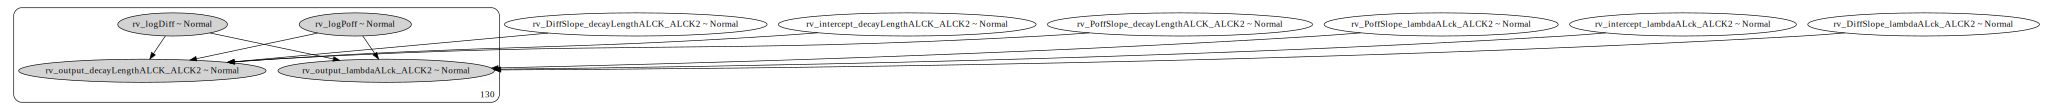

In [194]:
#@title Untrained model
use_wTCR = True

def get_pm_model2_untrained(df_trainingData_model2):  # model1
    
    pm_model2 = pm.Model()
    with pm_model2:
        dfRV = df_model2_untrainedTable
        DP = 'Distribution parameters'
        ### model1 - KS (kinetic segregation) #######################        
        # from class ################################################
        # model2.D:
        logPoff_LCKA2_obs = df_trainingData_model2.loc[:,'logPoff'].values
        logDiff_LCKA2_obs = df_trainingData_model2.loc[:,'logDiff'].values

        lambdaALck_ALCK2_obs = df_trainingData_model2.loc[:,'lambdaALCK'].values
        decayLengthALCK_ALCK2_obs = df_trainingData_model2.loc[:,'decayLengthALCK'].values
        
#         df_trainingData_model2['lambdaALCK']
        
        # rv_logPoff
        ID = 'fp_logPoff_lambdaALck_ALCK2'
        rv_logPoff = pm.Normal('rv_logPoff',
            mu = dfRV.loc[ID,DP]['mu'],
            sd = dfRV.loc[ID,DP]['sd'],
            observed = logPoff_LCKA2_obs)
        
        # rv_logDiff
        ID = 'fp_logDiff_lambdaALck_ALCK2'
        rv_logDiff = pm.Normal('rv_logDiff',
            mu = dfRV.loc[ID,DP]['mu'],
            sd = dfRV.loc[ID,DP]['sd'],
            observed = logDiff_LCKA2_obs) # todo values
        
        # lambdaALck ####################################################
        """TODO: read parameters values from RV table"""
        # rv_intercept_lambdaALck_ALCK2
        ID = 'rv_intercept_lambdaALck_ALCK2'
        rv_intercept_lambdaALck_ALCK2 = pm.Normal(ID, 
            mu = dfRV.loc[ID,DP]['mu'], 
            sd = dfRV.loc[ID,DP]['sd'])

        # rv_PoffSlope_lambdaALck_ALCK2
        ID = 'rv_PoffSlope_lambdaALck_ALCK2'
        rv_PoffSlope_lambdaALck_ALCK2 = pm.Normal(ID, 
            mu = dfRV.loc[ID,DP]['mu'], 
            sd = dfRV.loc[ID,DP]['sd']) 

        # rv_DiffSlope_lambdaALck_ALCK2
        ID = 'rv_DiffSlope_lambdaALck_ALCK2'
        rv_DiffSlope_lambdaALck_ALCK2 = pm.Normal(ID, 
            mu = dfRV.loc[ID,DP]['mu'], 
            sd = dfRV.loc[ID,DP]['sd']) 

        # rv_output_lambdaALck_ALCK21, equation:
        ID = 'rv_output_lambdaALck_ALCK2'
        rv_output_lambdaALck_ALCK2 = pm.Normal(ID, 
            mu = rv_intercept_lambdaALck_ALCK2 +\
            rv_PoffSlope_lambdaALck_ALCK2*rv_logPoff +\
            rv_DiffSlope_lambdaALck_ALCK2*rv_logDiff,
            sd = dfRV.loc[ID,DP]['sd'],
            observed = lambdaALck_ALCK2_obs) #

        # decayLengthALCK ####################################################
        """TODO: read parameters values from RV table"""
        # rv_intercept_decayLengthALCK_ALCK2
        ID = 'rv_intercept_decayLengthALCK_ALCK2'
        rv_intercept_decayLengthALCK_ALCK2 = pm.Normal(ID, 
            mu = dfRV.loc[ID,DP]['mu'], 
            sd = dfRV.loc[ID,DP]['sd'])

        # rv_PoffSlope_decayLengthALCK_ALCK2
        ID = 'rv_PoffSlope_decayLengthALCK_ALCK2'
        rv_PoffSlope_decayLengthALCK_ALCK2 = pm.Normal(ID, 
            mu = dfRV.loc[ID,DP]['mu'], 
            sd = dfRV.loc[ID,DP]['sd']) 

        # rv_DiffSlope_decayLengthALCK_ALCK2
        ID = 'rv_DiffSlope_decayLengthALCK_ALCK2'
        rv_DiffSlope_decayLengthALCK_ALCK2 = pm.Normal(ID, 
            mu = dfRV.loc[ID,DP]['mu'], 
            sd = dfRV.loc[ID,DP]['sd']) 

        # rv_output_decayLengthALCK_ALCK2, equation:
        ID = 'rv_output_decayLengthALCK_ALCK2'
        rv_output_decayLengthALCK_ALCK2 = pm.Normal(ID, 
            mu = rv_intercept_decayLengthALCK_ALCK2 +\
            rv_PoffSlope_decayLengthALCK_ALCK2*rv_logPoff +\
            rv_DiffSlope_decayLengthALCK_ALCK2*rv_logDiff,
            sd = dfRV.loc[ID,DP]['sd'],
            observed = decayLengthALCK_ALCK2_obs) #

        
        """
        eq = b + a1*x1 + a2*x2
        b = rv_intercept_dep_KSEG1
        a1 = rv_tSlope_dep_KSEG1
        x1 = rv_t
        a2 = rv_kSlope_dep_KSEG1
        x2 = rv_k
        """
        
        #############################################################
    return pm_model2

pm_model2= get_pm_model2_untrained(df_trainingData_model2) 
gv2 = pm.model_to_graphviz(pm_model2)
gv2  

In [10]:
if False:
    gv2.render("model2_graph", format="png")
    files.download("model2_graph.png") # Download locally from colab

In [196]:
with pm_model2:
    trace2 = pm.sample(2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_DiffSlope_decayLengthALCK_ALCK2, rv_PoffSlope_decayLengthALCK_ALCK2, rv_intercept_decayLengthALCK_ALCK2, rv_DiffSlope_lambdaALck_ALCK2, rv_PoffSlope_lambdaALck_ALCK2, rv_intercept_lambdaALck_ALCK2]
Sampling 4 chains, 0 divergences: 100%|█| 10000/10000 [05:53<00:00, 28.30draws/s]
The acceptance probability does not match the target. It is 0.9212730977035275, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9398726479726243, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.965040420

C:\Users\Owner\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


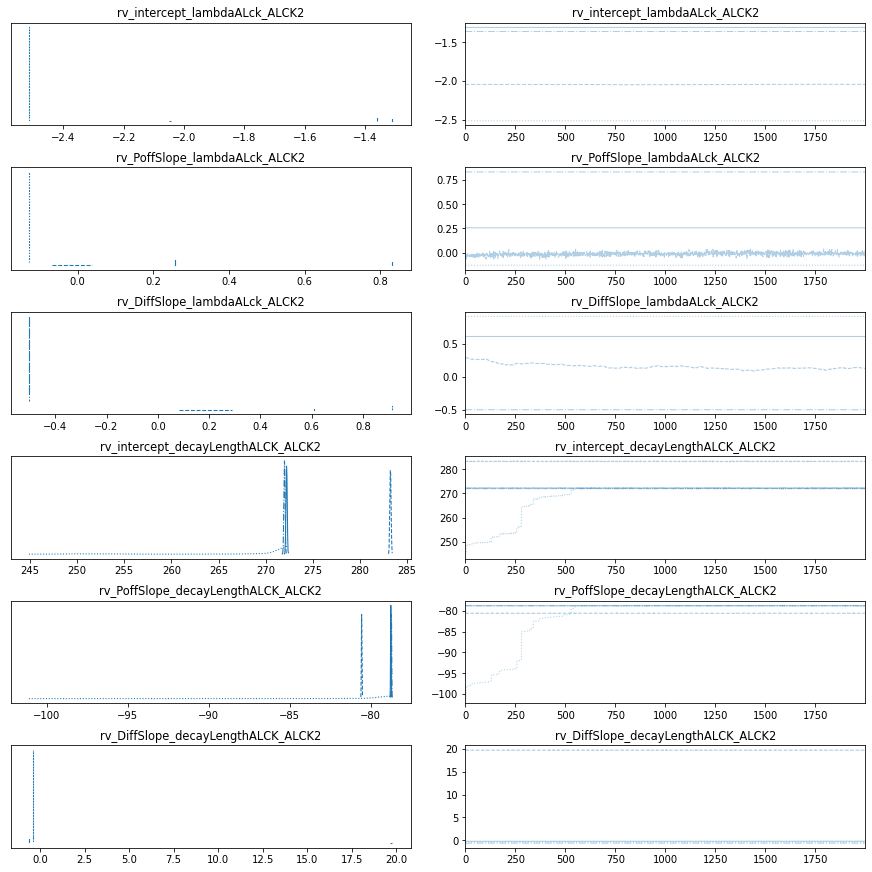

In [197]:
pm.traceplot(trace2);

In [13]:
# save trace_summary:
trace2_summary = pm.summary(trace2).round(3) # var_names=["mu", "tau"]
trace2_summary.to_pickle('trace2_summary')
if False: #True: # False
    files.download("trace2_summary") 
!ls

C:\Users\Owner\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [198]:
#@title Read 'mean' and 'sd' values from 'trace_summary'
# r = read, to distinguish between the original and the saved files.
trace2_summary_r = pd.read_pickle('trace2_summary') 

# displaying the rv names and the data of intersest: 'mean' and 'sd':
mean_sd_r = trace2_summary_r.loc[:, ['mean','sd']]
mean_sd_r

,mean,sd
rv_center_logDiff_lambdaALCK_LA2,-2.748,0.501
rv_center_logPoff_lambdaALCK_LA2,-0.095,0.425
rv_maxDiff_lambdaALCK_LA2,1.025,0.279
rv_devisor_logDiff_lambdaALCK_LA2,-1.216,0.215
rv_maxPoff_lambdaALCK_LA2,1.030,0.272
rv_devisor_logPoff_lambdaALCK_LA2,0.604,0.135
rv_noise_lambdaALCK_LA2,0.055,0.004


In [15]:
#@title Get trained model values
# exponent of logDiff sigmoid:
rv_tmp_x1_post = (logDiff_array - trace2_summary_r.loc['rv_center_logDiff_lambdaALCK_LA2','mean'])/\
                                  trace2_summary_r.loc['rv_devisor_logDiff_lambdaALCK_LA2','mean']

# logDiff sigmoid:
rv_tmp_sig1_post = trace2_summary_r.loc['rv_maxDiff_lambdaALCK_LA2','mean']/\
    (1 + np.exp(-rv_tmp_x1_post))

# exponent of logPoff sigmoid:
rv_tmp_x2_post = (logPoff_array - trace2_summary_r.loc['rv_center_logPoff_lambdaALCK_LA2','mean'])/\
                                  trace2_summary_r.loc['rv_devisor_logPoff_lambdaALCK_LA2','mean']
# logPoff sigmoid:
rv_tmp_sig2_post = trace2_summary_r.loc['rv_maxPoff_lambdaALCK_LA2','mean']/\
    (1 + np.exp(-rv_tmp_x2_post))

# lambdaALCK_validation:
lambdaALCK_validation = rv_tmp_sig1_post*rv_tmp_sig2_post

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


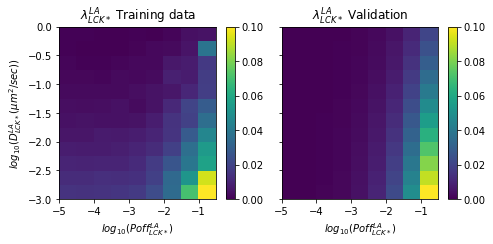

In [16]:
#@title Plot trainingData vs. trained Model
plot_contours = False

fig, ax0 = plt.subplots(1,2, figsize=[7, 3.5], sharey=True)
vmin0 = 0; vmax0 = 0.1 #150
im0 = ax0[0].pcolor(logPoff, logDiff, df_lambdaALCK, vmin=vmin0, vmax=vmax0)
if plot_contours:
    ax0[0].contour(logPoff, logDiff, df_lambdaALCK, vmin=vmin0, vmax=vmax0, colors='w')

fig.colorbar(im0, ax=ax0[0])
ax0[0].set_title('$\lambda_{LCK*}^{LA}$ Training data')
ax0[0].set_xlabel('$log_{10}(Poff_{LCK*}^{LA}$)')
ax0[0].set_ylabel('$log_{10}(D_{LCK*}^{LA}(\mu m^2/sec)$)')

###
im1 = ax0[1].pcolor(logPoff, logDiff, lambdaALCK_validation)
if plot_contours: 
    ax0[1].contour(logPoff, logDiff, rv_lambdaALCK_validation, 
                   vmin=vmin0, vmax=vmax0, colors='w')

fig.colorbar(im0, ax=ax0[1])
ax0[1].set_title('$\lambda_{LCK*}^{LA}$ Validation')
ax0[1].set_xlabel('$log_{10}(Poff_{LCK*}^{LA}$)')
# ax0[1].set_ylabel('$log_{10}(D_{LCK*}^{LA}(\mu m^2/sec)$)')
###

plt.tight_layout();

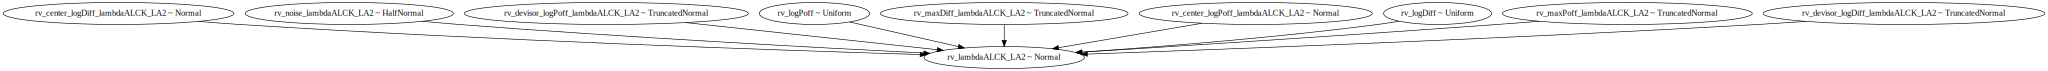

In [17]:
#@title Build trained model (with updated parameter estimates through their posteriors)
def get_model2_trained(trace2, logDiff_obs=None, logPoff_obs=None):
    ''' return model2 trained based on trace2. 
    If observed_t and/or observed_k are specified, 
    return the model conditioned on those values '''
    model2_trained = pm.Model()
    with model2_trained:
        ### model2 - LA (LCK activation) ###########################    
        # random variables x and y
        rv_logDiff = pm.Uniform('rv_logDiff', -3, 0, observed=logDiff_obs)
        rv_logPoff = pm.Uniform('rv_logPoff', -5, 0, observed=logPoff_obs)

        # random variables
        rv_noise_lambdaALCK_LA2 = pm.HalfNormal('rv_noise_lambdaALCK_LA2',
                                             sd=trace2.rv_noise_lambdaALCK_LA2.mean()) # noise 
        # Sigmoid params:
        # Diff sigmoid max:
        rv_maxDiff_lambdaALCK_LA2 = pm.TruncatedNormal('rv_maxDiff_lambdaALCK_LA2', 
                             mu = trace2_summary_r.loc['rv_maxDiff_lambdaALCK_LA2','mean'],
                             sd = trace2_summary_r.loc['rv_maxDiff_lambdaALCK_LA2','sd'],
                             lower = lower_rv_maxDiff_lambdaALCK_LA2,
                             upper = upper_rv_maxDiff_lambdaALCK_LA2)
        
        # Diff sigmoid center:
        rv_center_logDiff_lambdaALCK_LA2 = pm.Normal('rv_center_logDiff_lambdaALCK_LA2',
                           mu = trace2_summary_r.loc['rv_center_logDiff_lambdaALCK_LA2','mean'],
                           sd = trace2_summary_r.loc['rv_center_logDiff_lambdaALCK_LA2','sd'])
        
        # Diff sigmoid devisor:
        rv_devisor_logDiff_lambdaALCK_LA2 = pm.TruncatedNormal('rv_devisor_logDiff_lambdaALCK_LA2',
                                     mu = trace2_summary_r.loc['rv_devisor_logDiff_lambdaALCK_LA2','mean'],
                                     sd = trace2_summary_r.loc['rv_devisor_logDiff_lambdaALCK_LA2','sd'],
                                     lower = lower_rv_devisor_logDiff_lambdaALCK_LA2,
                                     upper = upper_rv_devisor_logDiff_lambdaALCK_LA2)
        
        # Poff sigmoid max:
        rv_maxPoff_lambdaALCK_LA2 = pm.TruncatedNormal('rv_maxPoff_lambdaALCK_LA2', 
                              mu = trace2_summary_r.loc['rv_maxPoff_lambdaALCK_LA2','mean'],
                              sd = trace2_summary_r.loc['rv_maxPoff_lambdaALCK_LA2','sd'],
                              lower = lower_rv_maxPoff_lambdaALCK_LA2,
                              upper = upper_rv_maxPoff_lambdaALCK_LA2)
        
        # Poff sigmoid center:        
        rv_center_logPoff_lambdaALCK_LA2 = pm.Normal('rv_center_logPoff_lambdaALCK_LA2',
                           mu = trace2_summary_r.loc['rv_center_logPoff_lambdaALCK_LA2','mean'],
                           sd = trace2_summary_r.loc['rv_center_logPoff_lambdaALCK_LA2','sd'])
        
        # Poff sigmoid devisor:
        rv_devisor_logPoff_lambdaALCK_LA2 = pm.TruncatedNormal('rv_devisor_logPoff_lambdaALCK_LA2', 
                                     mu = trace2_summary_r.loc['rv_devisor_logPoff_lambdaALCK_LA2','mean'], 
                                     sd = trace2_summary_r.loc['rv_devisor_logPoff_lambdaALCK_LA2','mean'],
                                     lower = lower_rv_devisor_logPoff_lambdaALCK_LA2,
                                     upper = upper_rv_devisor_logPoff_lambdaALCK_LA2)

        # exponent of logDiff sigmoid:
        rv_tmp_x1 = (rv_logDiff - rv_center_logDiff_lambdaALCK_LA2)/\
        rv_devisor_logDiff_lambdaALCK_LA2

        # logDiff sigmoid:
        rv_tmp_sig1 = rv_maxDiff_lambdaALCK_LA2/(1 + np.exp(-rv_tmp_x1))

        # exponent of logPoff sigmoid:
        rv_tmp_x2 = (rv_logPoff - rv_center_logPoff_lambdaALCK_LA2)/\
        rv_devisor_logPoff_lambdaALCK_LA2

        # logpoff sigmoid:
        rv_tmp_sig2 = rv_maxPoff_lambdaALCK_LA2/(1 + np.exp(-rv_tmp_x2))

        # lambdaALCK:
        rv_lambdaALCK_LA2 = pm.Normal('rv_lambdaALCK_LA2', 
                                       mu = rv_tmp_sig1*rv_tmp_sig2,
                                       sd = rv_noise_lambdaALCK_LA2)

    return model2_trained   

model2_trained= get_model2_trained(trace2)
gv2 = pm.model_to_graphviz(model2_trained)
display(gv2)


In [18]:
n_logDiff = 2 #26 
n_logPoff = 2 #25 
logDiffs = np.linspace(-3, 0, n_logDiff)
logPoffs = np.linspace(-5, 0, n_logPoff)

lambdas_mean = np.zeros((n_logDiff, n_logPoff))
lambdas_std = np.zeros((n_logDiff, n_logPoff))

for i,ld in enumerate(logDiffs):
    for j,lp in enumerate(logPoffs):
        #try:
        cur_model = get_model2_trained(trace2, logDiff_obs=ld, logPoff_obs=lp)
        with cur_model:
            cur_trace = pm.sample(2000, chains=4, progressbar = False);
        print(f"i,ld={i,ld}, j,lp={j,lp}")
        # display(pm.summary(cur_trace).round(3))
        lambdas_mean[i,j] = cur_trace.rv_lambdaALCK_LA2.mean() 
        lambdas_std[i,j] = cur_trace.rv_lambdaALCK_LA2.std()
        #except ValueError:   



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_lambdaALCK_LA2, rv_devisor_logPoff_lambdaALCK_LA2, rv_center_logPoff_lambdaALCK_LA2, rv_maxPoff_lambdaALCK_LA2, rv_devisor_logDiff_lambdaALCK_LA2, rv_center_logDiff_lambdaALCK_LA2, rv_maxDiff_lambdaALCK_LA2, rv_noise_lambdaALCK_LA2]
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 550 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.531134785868933, but should be close to 0.8. Try to increase the number of tuning steps.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective sampl

i,ld=(0, -3.0), j,lp=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_lambdaALCK_LA2, rv_devisor_logPoff_lambdaALCK_LA2, rv_center_logPoff_lambdaALCK_LA2, rv_maxPoff_lambdaALCK_LA2, rv_devisor_logDiff_lambdaALCK_LA2, rv_center_logDiff_lambdaALCK_LA2, rv_maxDiff_lambdaALCK_LA2, rv_noise_lambdaALCK_LA2]
There were 280 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6481975652084077, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1229 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23957628622037802, but should be close to 0.8. Try to increase the number of tuning steps.
There were 434 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.591185992766929

i,ld=(0, -3.0), j,lp=(1, 0.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_lambdaALCK_LA2, rv_devisor_logPoff_lambdaALCK_LA2, rv_center_logPoff_lambdaALCK_LA2, rv_maxPoff_lambdaALCK_LA2, rv_devisor_logDiff_lambdaALCK_LA2, rv_center_logDiff_lambdaALCK_LA2, rv_maxDiff_lambdaALCK_LA2, rv_noise_lambdaALCK_LA2]
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6787658013567093, but should be close to 0.8. Try to increase the number of tuning steps.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


i,ld=(1, 0.0), j,lp=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_lambdaALCK_LA2, rv_devisor_logPoff_lambdaALCK_LA2, rv_center_logPoff_lambdaALCK_LA2, rv_maxPoff_lambdaALCK_LA2, rv_devisor_logDiff_lambdaALCK_LA2, rv_center_logDiff_lambdaALCK_LA2, rv_maxDiff_lambdaALCK_LA2, rv_noise_lambdaALCK_LA2]
There were 341 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6607822042676913, but should be close to 0.8. Try to increase the number of tuning steps.
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7099706459309442, but should be close to 0.8. Try to increase the number of tuning steps.
There were 374 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6719294390832092,

i,ld=(1, 0.0), j,lp=(1, 0.0)


In [19]:
print(lambdas_mean)
print(lambdaALCK_validation[0,0])
print(lambdaALCK_validation[-1,0])
print(lambdaALCK_validation[0,-1])
print(lambdaALCK_validation[-1,-1])

[[0.00622185 0.31500502]
 [0.00098072 0.05579054]]
0.00017307348069457905
2.965010292934014e-05
0.1970639131859886
0.03376002658624593


In [20]:
if False:
    np.save("model2_trained_lambdaALCK_LA2_mean", lambdas_mean)
    np.save("model2_trained_lambdaALCK_LA2_std", lambdas_std)
    !ls

In [21]:
if False:
    from google.colab import files
    files.download("model2_trained_lambdaALCK_LA2_mean.npy") # Download locally from colab
    files.download("model2_trained_lambdaALCK_LA2_std.npy") # Download locally from colab


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the c

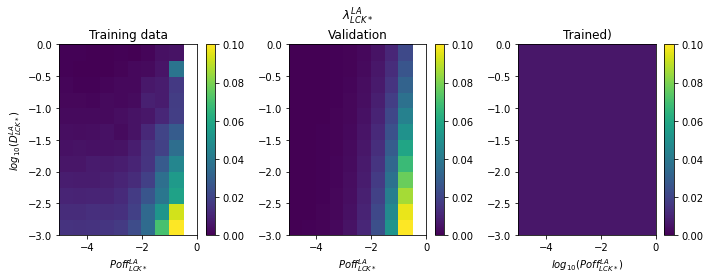

In [22]:
fig, ax0 = plt.subplots(1,3, figsize=[10,4], sharex=True)

vmin0 = 0; vmax0 = 0.1 
im0 = ax0[0].pcolor(logPoff, logDiff, df_lambdaALCK, \
   vmin=vmin0, vmax=vmax0)
if plot_contours:
    ax0[0].contour(logPoff, logDiff, df_lambdaALCK, \
    vmin=vmin0, vmax=vmax0, colors='w')
fig.colorbar(im0, ax=ax0[0])
ax0[0].set_title('Training data')
ax0[0].set_xlabel('$Poff_{LCK*}^{LA}$')
ax0[0].set_ylabel('$log_{10}(D_{LCK*}^{LA}$)')

### validation
im1 = ax0[1].pcolor(logPoff, logDiff, lambdaALCK_validation, \
    vmin=vmin0, vmax=vmax0)
if plot_contours:
    ax0[1].contour(logPoff, logDiff, lambdaALCK_validation, \
    vmin=vmin0, vmax=vmax0, colors='w') # vmin=vmin6, vmax=vmax6,
fig.colorbar(im1, ax=ax0[1])
ax0[1].set_title('$\lambda_{LCK*}^{LA}$\nValidation')
ax0[1].set_xlabel('$Poff_{LCK*}^{LA}$')
# ax0[1].set_ylabel('$log_{10}(D_{LCK*}^{LA})$')

if True:
    ### trainded
    im2 = ax0[2].pcolor(logPoffs, logDiffs, lambdas_mean, \
        vmin=vmin0, vmax=vmax0)
    if plot_contours:
        ax0[2].contour(log_Poffs, log_Diffs, Zs_mean, \
        vmin=vmin0, vmax=vmax0, colors='w')
    fig.colorbar(im1, ax=ax0[2])
    ax0[2].set_title('\nTrained)')
    ax0[2].set_xlabel('$log_{10}(Poff_{LCK*}^{LA})$')
    # ax0[2].set_ylabel('$log_{10}(D_{LCK*}^{LA})$')
    ###

plt.tight_layout();

In [8]:
#@title Untrained values of random variables
# maxDiff:
mu_rv_maxDiff_lambdaALCK_LA2 = 1.0
sd_rv_maxDiff_lambdaALCK_LA2 = 0.3
lower_rv_maxDiff_lambdaALCK_LA2 = 0.0
upper_rv_maxDiff_lambdaALCK_LA2 = None

# center_logDiff:
mu_rv_center_logDiff_lambdaALCK_LA2 = -3.0
sd_rv_center_logDiff_lambdaALCK_LA2 = 0.5

# devisor_logDiff:
mu_rv_devisor_logDiff_lambdaALCK_LA2 = -0.7
sd_rv_devisor_logDiff_lambdaALCK_LA2 = 0.3
lower_rv_devisor_logDiff_lambdaALCK_LA2 = None
upper_rv_devisor_logDiff_lambdaALCK_LA2 = 0

# maxPoff:
mu_rv_maxPoff_lambdaALCK_LA2 = 1.0
sd_rv_maxPoff_lambdaALCK_LA2 = 0.3
lower_rv_maxPoff_lambdaALCK_LA2 = 0.0
upper_rv_maxPoff_lambdaALCK_LA2 = None

# center_logPoff:
mu_rv_center_logPoff_lambdaALCK_LA2 = 0
sd_rv_center_logPoff_lambdaALCK_LA2 = 1.0

# devisor_logPoff:
mu_rv_devisor_logPoff_lambdaALCK_LA2 = 0.5
sd_rv_devisor_logPoff_lambdaALCK_LA2 = 0.2
lower_rv_devisor_logPoff_lambdaALCK_LA2 = 0
upper_rv_devisor_logPoff_lambdaALCK_LA2 = None

# noise:
sd_noise_lambdaALCK_LA2 = 0.2

In [7]:
#@title Initial fit for the untrained data
if False:
    Diff_ind = 2
    Poff_ind = 8


    # min1 = 0
    maxPoff = 1.2 #0.3
    cenPoff = -0.0
    devPoff = 0.7
    sigPoff = maxPoff/(1 + np.exp(-(logPoff - cenPoff)/devPoff))
    sigPoff_array = maxPoff/(1 + np.exp(-(logPoff_array - cenPoff)/devPoff))

    # min2 = 0
    maxDiff = 1.0 #0.2
    cenDiff = -3
    devDiff = -0.7
    sigDiff = maxDiff/(1 + np.exp(-(logDiff - cenDiff)/devDiff))
    sigDiff_array = maxDiff/(1 + np.exp(-(logDiff_array - cenDiff)/devDiff))

    test_array = sigPoff_array * sigDiff_array


    fig, ax1 = plt.subplots(1,4, figsize=[13, 3.5])
    vmin0 = 0
    vmax0 = 0.1
    im0 = ax1[0].pcolor(logPoff, logDiff, lambdaALCK_array, vmin=vmin0, vmax=vmax0)
    ax1[0].contour(logPoff, logDiff, lambdaALCK_array, colors='w', vmin=vmin0, vmax=vmax0)
    fig.colorbar(im0, ax=ax1[0])
    ax1[0].plot([-5, -0.5],[logDiff[Diff_ind], logDiff[Diff_ind]],'-', color=[0.2, 0.5, 1.0])
    ax1[0].plot([logPoff[Poff_ind], logPoff[Poff_ind]],[-3, 0],'--', color=[0.2, 0.5, 1.0])
    ax1[0].set_title('$\lambda_{LCK*}^{LA}$ Evidence')
    ax1[0].set_xlabel('$log_{10}(Poff_{LCK*}^{LA}$)')
    ax1[0].set_ylabel('$log_{10}(D_{LCK*}^{LA}(\mu m^2/sec)$)');

    ax1[1].plot(logPoff, lambdaALCK_array[Diff_ind,:])
    ax1[1].plot(logPoff, sigPoff)
    ax1[1].set_xlabel('$log_{10}Poff$')

    ax1[2].plot(logDiff, lambdaALCK_array[:,Poff_ind],'--')
    ax1[2].plot(logDiff, sigDiff,'--')
    ax1[2].set_xlabel('$log_{10}Diff$')

    im3 = ax1[3].pcolor(logPoff, logDiff, test_array, vmin=vmin0, vmax=vmax0) #, vmin=vmin0, vmax=vmax0
    ax1[3].contour(logPoff, logDiff, test_array,colors='w', vmin=vmin0, vmax=vmax0)
    fig.colorbar(im3, ax=ax1[3])
    ax1[3].set_title('$\lambda_{LCK*}^{LA}$ Test')
    ax1[3].set_xlabel('$log_{10}(Poff_{LCK*}^{LA}$)')
    ax1[3].set_ylabel('$log_{10}(D_{LCK*}^{LA}(\mu m^2/sec)$)');

    plt.tight_layout()

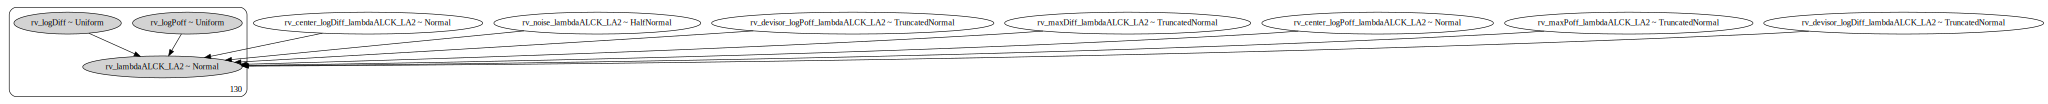

In [9]:
#@title Untrained model
### model2 - LA (LCK activation) ####################################
def get_model2_untrained(df_trainingData_model2):
    
    model2 = pm.Model()
    with model2:
        logDiff_array, logPoff_array, lambdaALCK_array
        ### model1 - KS (kinetic segregation) ###########################        
        logPoff_input = df_trainingData_model2.loc[:,'logPoff'].values
        logDiff_input = df_trainingData_model2.loc[:,'logDiff'].values
        lambdaALCK_obs = df_trainingData_model2.loc[:,'lambdaALCK'].values

        
        rv_logDiff = pm.Uniform('rv_logDiff', -3, 0, observed=logDiff_input)
        rv_logPoff = pm.Uniform('rv_logPoff', -5, 0, observed=logPoff_input)

        #####################################################################

        # maxDiff lambdaALCK:
        rv_maxDiff_lambdaALCK_LA2 = \
            pm.TruncatedNormal('rv_maxDiff_lambdaALCK_LA2',
                                mu = mu_rv_maxDiff_lambdaALCK_LA2,
                                sd = sd_rv_maxDiff_lambdaALCK_LA2,
                                lower = lower_rv_maxDiff_lambdaALCK_LA2,
                                upper = upper_rv_maxDiff_lambdaALCK_LA2)
        
        # center_logDiff:
        rv_center_logDiff_lambdaALCK_LA2 = \
            pm.Normal('rv_center_logDiff_lambdaALCK_LA2',
                    mu = mu_rv_center_logDiff_lambdaALCK_LA2, 
                    sd = sd_rv_center_logDiff_lambdaALCK_LA2)

        # devisor_logDiff:
        rv_devisor_logDiff_lambdaALCK_LA2 = \
            pm.TruncatedNormal('rv_devisor_logDiff_lambdaALCK_LA2',
                                mu = mu_rv_devisor_logDiff_lambdaALCK_LA2, 
                                sd = sd_rv_devisor_logDiff_lambdaALCK_LA2,
                                lower = lower_rv_devisor_logDiff_lambdaALCK_LA2,
                                upper = upper_rv_devisor_logDiff_lambdaALCK_LA2)
        
        # maxPoff:
        rv_maxPoff_lambdaALCK_LA2 = \
            pm.TruncatedNormal('rv_maxPoff_lambdaALCK_LA2',
                                mu = mu_rv_maxPoff_lambdaALCK_LA2,
                                sd = sd_rv_maxPoff_lambdaALCK_LA2,
                                lower = lower_rv_maxPoff_lambdaALCK_LA2,
                                upper = upper_rv_maxPoff_lambdaALCK_LA2)
        
        # center_logPoff:
        rv_center_logPoff_lambdaALCK_LA2 = \
            pm.Normal('rv_center_logPoff_lambdaALCK_LA2',
                    mu = mu_rv_center_logPoff_lambdaALCK_LA2, 
                    sd = sd_rv_center_logPoff_lambdaALCK_LA2)
         
        # devisor_logPoff:
        rv_devisor_logPoff_lambdaALCK_LA2 = \
            pm.TruncatedNormal('rv_devisor_logPoff_lambdaALCK_LA2',
                                mu = mu_rv_devisor_logPoff_lambdaALCK_LA2,
                                sd = sd_rv_devisor_logPoff_lambdaALCK_LA2,
                                lower = lower_rv_devisor_logPoff_lambdaALCK_LA2,
                                upper = upper_rv_devisor_logPoff_lambdaALCK_LA2)

        # noise:
        rv_noise_lambdaALCK_LA2 = \
            pm.HalfNormal('rv_noise_lambdaALCK_LA2',
                        sd = sd_noise_lambdaALCK_LA2)

        # exponent of logDiff sigmoid:
        rv_tmp_x1 = (rv_logDiff - rv_center_logDiff_lambdaALCK_LA2)/\
            rv_devisor_logDiff_lambdaALCK_LA2

        # logDiff sigmoid:
        rv_tmp_sig1 = rv_maxDiff_lambdaALCK_LA2/(1 + np.exp(-rv_tmp_x1))
        
        # exponent of logPoff sigmoid:
        rv_tmp_x2 = (rv_logPoff - rv_center_logPoff_lambdaALCK_LA2)/\
            rv_devisor_logPoff_lambdaALCK_LA2

        # logPoff sigmoid:
        rv_tmp_sig2 = rv_maxPoff_lambdaALCK_LA2/(1 + np.exp(-rv_tmp_x2))

        # lambdaALCK:
        rv_lambdaALCK_LA2 = \
            pm.Normal('rv_lambdaALCK_LA2', 
            mu = rv_tmp_sig1*rv_tmp_sig2,
            sd=rv_noise_lambdaALCK_LA2, 
            observed=lambdaALCK_obs)
        
    return model2    

model2 = get_model2_untrained(df_trainingData_model2)
gv2 = pm.model_to_graphviz(model2)
gv2